# Index

# Modules and tools :

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn', Mutes warnings when copying a slice from a DataFrame.
import numpy as np
import scipy.stats as st
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
from datetime import datetime, date, time
import requests
import plotly.express as px
import os

# Introduction

### Beer dataset

The dataset come from two different websites, from 2001 to 2007 (17years) : https://www.ratebeer.com/ and https://www.beeradvocate.com/. This two platform where one can review and share about beers. Technically it consists of three csv files and two txt files for each websites :
1) beers.csv : informations about the beers
2) breweries.csv : informations about the breweries
3) users.csv : informations about the users
4) rating.txt : all the different rating for each beer
5) reviews.txt : all the different review for each beer

There is also matched dataset between the two websites.

In [2]:
BA_dir = './datasets/BeerAdvocate/'
BA_sample_file = f'{BA_dir}/reviews_sample.txt'
BA_users_file = f'{BA_dir}/users.csv'
BA_breweries_file = f'{BA_dir}/breweries.csv'
RB_dir = './datasets/RateBeer/'
RB_sample_file = f'{RB_dir}/reviews_sample.txt'
RB_users_file = f'{RB_dir}/users.csv'
RB_breweries_file = f'{RB_dir}/breweries.csv'

In [3]:
BA_beers_file = f'{BA_dir}/beers.csv'
RB_beers_file = f'{RB_dir}/beers.csv'

### Is it too big ?
One thing to consider when handling large dataset is there size, here we will try to see if it's problem.

For our project we will only need the beer, breweries and users file of each website.

In [4]:
def file_sizeMB(file_name):
    stat = os.stat(file_name)
    return stat.st_size / (1024*1024)

complete_size = 0
#for BeerAdvocate
for filename in os.listdir(BA_dir):
    file = os.path.join(BA_dir, filename)
    if os.path.isfile(file):
        print(f'{file} size in MegaBytes is {file_sizeMB(str(file))}')
        complete_size += file_sizeMB(str(file))
#for RateBeer
for filename in os.listdir(RB_dir):
    file = os.path.join(RB_dir, filename)
    if os.path.isfile(file):
        print(f'{file} size in MegaBytes is {file_sizeMB(str(file))}')
        complete_size += file_sizeMB(str(file))


print(complete_size)


./datasets/BeerAdvocate/BA_reviews.tar.gz size in MegaBytes is 71.24130630493164
./datasets/BeerAdvocate/beers.csv size in MegaBytes is 28.51298713684082
./datasets/BeerAdvocate/breweries.csv size in MegaBytes is 0.7867345809936523
./datasets/BeerAdvocate/reviews_sample.txt size in MegaBytes is 66.88321495056152
./datasets/BeerAdvocate/users.csv size in MegaBytes is 9.446638107299805
./datasets/RateBeer/beers.csv size in MegaBytes is 45.43974685668945
./datasets/RateBeer/breweries.csv size in MegaBytes is 1.013178825378418
./datasets/RateBeer/RB_reviews_1.tar.gz size in MegaBytes is 84.52471446990967
./datasets/RateBeer/RB_reviews_2.tar.gz size in MegaBytes is 67.54720973968506
./datasets/RateBeer/reviews_sample.txt size in MegaBytes is 0.025028228759765625
./datasets/RateBeer/users.csv size in MegaBytes is 3.1213817596435547
378.54214096069336


The file size of each dataset and format (.csv) can be handle pretty easily without any particular issues that we can think of.

### What's the model of our data and what's in it?
Let's take a look at the data given by BeerAdvocate :

In [5]:
user_ba = pd.read_csv(BA_users_file)
user_ba.head(10)

,nbr_ratings,nbr_reviews,user_id,user_name,joined,location
0,7820,465,nmann08.184925,nmann08,1.199704e+09,"United States, Washington"
1,2521,2504,stjamesgate.163714,StJamesGate,1.191838e+09,"United States, New York"
2,1797,1143,mdagnew.19527,mdagnew,1.116410e+09,Northern Ireland
3,31,31,helloloser12345.10867,helloloser12345,1.101380e+09,Northern Ireland
4,604,604,cypressbob.3708,cypressbob,1.069326e+09,Northern Ireland
5,2326,0,hellpop65.48993,Hellpop65,1.131966e+09,"United States, Kansas"
6,3098,0,latarnik.52897,Latarnik,1.133521e+09,"United States, New Jersey"
7,1866,23,rochefortchris.697017,RochefortChris,1.349172e+09,"United States, North Carolina"
8,1131,188,okcnittany.144868,OKCNittany,1.182766e+09,"United States, Oklahoma"
9,9987,16,jaydoc.265507,jaydoc,1.226488e+09,"United States, Kansas"


In [6]:
beers_ba = pd.read_csv(BA_beers_file)
beers_ba.head(10)

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
0,166064,Nashe Moskovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.7,NaN,NaN,0,NaN
1,166065,Nashe Pivovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,3.8,NaN,NaN,0,NaN
2,166066,Nashe Shakhterskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.8,NaN,NaN,0,NaN
3,166067,Nashe Zhigulevskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.0,NaN,NaN,0,NaN
4,166063,Zhivoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.5,NaN,NaN,0,NaN
5,166068,Arpa,39913,Arpa (АРПА),Euro Pale Lager,0,0,NaN,NaN,NaN,4.0,NaN,NaN,0,NaN
6,166071,Eles,39914,Bear Beer,Euro Pale Lager,0,0,NaN,NaN,NaN,4.0,NaN,NaN,0,NaN
7,166072,Eles Light,39914,Bear Beer,Euro Pale Lager,0,0,NaN,NaN,NaN,3.2,NaN,NaN,0,NaN
8,166074,Toroz Svetloye,39914,Bear Beer,American Pale Lager,0,0,NaN,NaN,NaN,4.5,NaN,NaN,0,NaN
9,166076,Toroz Temnoye,39914,Bear Beer,Euro Dark Lager,0,0,NaN,NaN,NaN,4.1,NaN,NaN,0,NaN


In [7]:
breweries_ba = pd.read_csv(BA_breweries_file)
breweries_ba.head(10)

,id,location,name,nbr_beers
0,39912,Kyrgyzstan,Abdysh-Ata (Абдыш Ата),5
1,39913,Kyrgyzstan,Arpa (АРПА),1
2,39914,Kyrgyzstan,Bear Beer,4
3,39915,Kyrgyzstan,Blonder Pub,4
4,39916,Kyrgyzstan,Kellers Bier,2
5,16051,Kyrgyzstan,Pivzavod Uzgen,0
6,16052,Kyrgyzstan,Steinbrau Pub,4
7,39917,Kyrgyzstan,Usu-Salkin Pivo,3
8,37262,Gabon,Societe des Brasseries du Gabon (SOBRAGA),1
9,10093,Northern Ireland,Strangford Lough Brewing Company Ltd,5


As we can see it seems that the data are stored in a relational model (i.e., the index ```brewery_id``` in the beers.csv dataset is the foreign key that point to the primary key ```id``` in the breweries.csv. 

We can confirm our observation with a prelimenary check on the name of the brewery for the first row of ```beer_ba```: 

In [8]:
beers_ba.iloc[0].brewery_name == breweries_ba[breweries_ba.id == beers_ba.iloc[0].brewery_id].name

0    True
Name: name, dtype: bool

Ok so we have our first confirmation, we should make sure that there is no problem with the attribution of the key by performing the test for each rows but for now let assume there is no issues.

Concerning what's in the data we can see that for the breweries and users dataset the name colunm are pretty straightforward and speaks for itself. Concerning the beers dataset some name colunm are understandable by themself and other don't. For now there is a lot of NaN values (one thing to notice is that even if a beer doesn't have rating it is still in the dataset). Maybe looking at other value will help understand.

In [9]:
beers_ba[~beers_ba.isna().any(axis=1)].head()

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
25,19827,Legbiter,10093,Strangford Lough Brewing Company Ltd,English Pale Ale,75,59,3.45,80.0,80.0,4.8,3.439867,-0.649167,59,3.504068
27,20842,St. Patrick's Best,10093,Strangford Lough Brewing Company Ltd,English Bitter,64,48,3.56,82.0,90.0,4.2,3.556094,-0.478579,48,3.580417
3231,18650,Tawny Owl,6872,Cotleigh Brewery,English Bitter,20,16,3.71,84.0,80.0,3.8,3.707000,-0.216512,16,3.680625
6185,21,Deep Shaft Stout,18,Freeminer Brewery Ltd.,Foreign / Export Stout,66,66,4.25,90.0,94.0,6.2,4.254848,0.751762,66,4.254848
6194,856,Shakemantle Ginger Ale,18,Freeminer Brewery Ltd.,Herbed / Spiced Beer,12,12,3.75,84.0,86.0,5.0,3.750000,-0.128881,12,3.750000


1) ```avg``` is the the average rating out of 5 showing in the website for a particular beer.
2) ```avg_computed``` is the average score out of 5 computed with the combination of a weighted sum of the 5 different aspect of rating
3) ```zscore``` is the standardized score to compare the two website used in this paper https://dlab.epfl.ch/people/west/pub/Lederrey-West_WWW-18.pdf

In [10]:
# The datasets' location in the repository:

sample_file = 'datasets/BeerAdvocate/reviews_sample.txt'
users_file = 'datasets/BeerAdvocate/users.csv'
breweries_file = 'datasets/BeerAdvocate/breweries.csv'
beers_file = 'datasets/BeerAdvocate/beers.csv'
directory_BA = 'datasets/BeerAdvocate'
directory_RB = 'datasets/RateBeer'

# 0. Data cleaning

### Helper functions:

In [11]:
def transform_values(df):
    try:
        df['user_id'] = df['user_id'].astype(int)
    except:
        df['user_id'] = df['user_id'].apply(lambda x: str(x).strip())

    for field in ['beer_name', 'brewery_name', 'style']:
        df[field] = df[field].apply(lambda x: str(x).strip())
    for column_name in ['brewery_id', 'beer_id']:
        df[column_name] = df[column_name].astype(int)
    for column_name in ['abv', 'appearance', 'aroma', 'palate', 'taste', 'overall', 'rating']:
        df[column_name] = df[column_name].astype(float)
    df['review'] = df['review'].astype(bool)

    df['date'] = df['date'].apply(lambda x: datetime.fromtimestamp(int(x)))
    return df


def read_full_reviews_file(csv_file):
    colnames = ['beer_name', 'beer_id', 'brewery_name', 'brewery_id', 'style', 'abv', 'date', 'user_name', 'user_id', 'appearance', 'aroma', 'palate', 'taste', 'overall', 'rating']
    df = pd.read_csv(csv_file, sep='\|\|\|', names=colnames, engine='python')
    return df


def read_sample_reviews_file(file_path):
    def parse_dict(lines):
        result = {}
        for line in lines:
            key, value = line.split(':', 1)
            value = value.split('\n')[0]
            result[key] = value
        return result


    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    blank_lines_indexes = [index for index, line in enumerate(lines) if line.isspace()]

    data = []
    begin_index = 0
    for end_index in blank_lines_indexes:
        result_dict = parse_dict(lines[begin_index:end_index])
        data.append(result_dict)
        begin_index = end_index + 1
    df = pd.DataFrame(data)
    if not 'review' in list(df.columns):
        df['review'] = df.text.apply(lambda x: True if x else False)
    return transform_values(df)

convertion_dict = {
    'virgin islands (british)' : {
        'country': 'england',
        'state': 'virgin islands'
    },
    'virgin islands (u.s.)' : {
        'country': 'united states',
        'state': 'virgin islands'
    },
    'utah' : {
        'country': 'united states',
        'state': 'utah'
    },
    'illinois' : {
        'country': 'united states',
        'state': 'illinois'
    },
    'new york' : {
        'country': 'united states',
        'state': 'new york'
    }
}
def get_state_str(x):
    if x in convertion_dict.keys():
        return convertion_dict[x]['state']
    splitted = str(x).lower().strip().split(',')
    if len(splitted) > 1:
        return splitted[-1]
    return np.nan

def get_country_str(x):
    if x in convertion_dict.keys():
        return convertion_dict[x]['country']
    return str(x).lower().strip().split(',')[0]

def remove_links(x:str):
    token = '</a>'
    if token in x:
        return x.split(token)[0]
    return x

def regularize_locations(df):
    df['state'] = df['location'].apply(lambda x: get_state_str(x))
    df['location'] = df['location'].apply(lambda x: get_country_str(remove_links(str(x))))
    return df

In [12]:
# https://fr.wikipedia.org/wiki/Liste_des_pays_par_population#Notes

population_dict = {
    'united states' : 334805000,
    'canada' : 38388000,
    'england' : 68992721,
    'australia' : 26069000,
    'scotland' : 5078400,
    'germany' : 83809425,
    'russia' : 146083065,
    'netherlands' : 17211000,
    'sweden' : 10219000,
    'romania' : 1903100,
    'ireland' : 5020000,
    'italy' : 60263000,
    'northern ireland' : 1810863,
    'belgium' : 11668000,
    'spain' : 46719000,
    'finland' : 5555000,
    'france' : 67813396,
    'switzerland' : 8774000,
    'brazil' : 215354000,
    'hong kong' : 7604000 
}

In [13]:
BA_df = read_sample_reviews_file(BA_sample_file)
BA_df.dtypes

beer_name               object
beer_id                  int32
brewery_name            object
brewery_id               int32
style                   object
abv                    float64
date            datetime64[ns]
user_name               object
user_id                 object
appearance             float64
aroma                  float64
palate                 float64
taste                  float64
overall                float64
rating                 float64
text                    object
review                    bool
dtype: object

In [14]:
BA_df.head(2)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review
0,Régab,142544,Societe des Brasseries du Gabon (SOBRAGA),37262,Euro Pale Lager,4.5,2015-08-20 12:00:00,nmann08,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88,"From a bottle, pours a piss yellow color with...",True
1,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,2009-02-20 12:00:00,StJamesGate,stjamesgate.163714,3.00,3.50,3.50,4.00,3.5,3.67,Pours pale copper with a thin head that quick...,True


In [15]:
BA_users = pd.read_csv(BA_users_file)
BA_users = regularize_locations(BA_users)
print(len(BA_users))
BA_users.dtypes

153704


nbr_ratings      int64
nbr_reviews      int64
user_id         object
user_name       object
joined         float64
location        object
state           object
dtype: object

In [16]:
BA_users.head(3)

,nbr_ratings,nbr_reviews,user_id,user_name,joined,location,state
0,7820,465,nmann08.184925,nmann08,1.199704e+09,united states,washington
1,2521,2504,stjamesgate.163714,StJamesGate,1.191838e+09,united states,new york
2,1797,1143,mdagnew.19527,mdagnew,1.116410e+09,northern ireland,NaN


# 1. Repartition of data around the world

In order to match a person with a beer, first we will see a descriptive analysis. In this part, we will have a general repartion of our data in the world.

In this way, we will see how beer production is distributed around the globe and how users are distributed and their " enthusiasm " across the world. This will allow us to have a global view of our data and see if regions are more active or more enthusiastic to take this into account for the following in order to know if users prefer beers from their own country. In fact, we will use the origin of the person to match a personn with a beer. Thus it seems important to check for how many of the countries we have enough data to proceed and if there is a correlation between beer production and actvity of users.

## How beer production is distributed around the globe?

#### The dataset of breweries:

In [17]:
BA_breweries = pd.read_csv(BA_breweries_file)
BA_breweries = regularize_locations(BA_breweries)
print(f'Number of breweries = {len(BA_breweries)}')
BA_breweries.head(10)

Number of breweries = 16758


,id,location,name,nbr_beers,state
0,39912,kyrgyzstan,Abdysh-Ata (Абдыш Ата),5,NaN
1,39913,kyrgyzstan,Arpa (АРПА),1,NaN
2,39914,kyrgyzstan,Bear Beer,4,NaN
3,39915,kyrgyzstan,Blonder Pub,4,NaN
4,39916,kyrgyzstan,Kellers Bier,2,NaN
5,16051,kyrgyzstan,Pivzavod Uzgen,0,NaN
6,16052,kyrgyzstan,Steinbrau Pub,4,NaN
7,39917,kyrgyzstan,Usu-Salkin Pivo,3,NaN
8,37262,gabon,Societe des Brasseries du Gabon (SOBRAGA),1,NaN
9,10093,northern ireland,Strangford Lough Brewing Company Ltd,5,NaN


In [18]:
RB_breweries = pd.read_csv(RB_breweries_file)
RB_breweries = regularize_locations(RB_breweries)
print(f'Number of breweries = {len(RB_breweries)}')
RB_breweries.head(10)

Number of breweries = 24189


,id,location,name,nbr_beers,state
0,3198,gabon,Sobraga,3,NaN
1,13538,northern ireland,Ards Brewing Co.,13,NaN
2,22304,northern ireland,Barrahooley Craft Brewery,4,NaN
3,22818,northern ireland,Boundary,66,NaN
4,24297,northern ireland,Brewbot Belfast,3,NaN
5,27006,northern ireland,Bullhouse Brewing Company,6,NaN
6,12090,northern ireland,Clanconnel,7,NaN
7,18096,northern ireland,Clearsky,3,NaN
8,19858,northern ireland,Cloughmore,3,NaN
9,19507,northern ireland,Farmageddon Brewing Co-Op,23,NaN


In [19]:
# Remove hyperlinks
for index in BA_breweries.iterrows():
    location = BA_breweries['location'][index[0]]
    if '</a>' in location:
        BA_breweries['location'][index[0]] = BA_breweries['location'][index[0]].partition('</a>')[0]

# Remove the breweries which propose 0 beer
BA_breweries = BA_breweries[BA_breweries['nbr_beers'] >= 1]

In [20]:
# join the two dataframe
breweries = pd.concat([BA_breweries, RB_breweries])
breweries = breweries.drop_duplicates(subset=['id'], keep='first')

In [21]:
print(f'Number of breweries = {len(breweries)}')
print(f'Number of different contries from breweries = {len(list(breweries.location.unique()))}')

Number of breweries = 32587
Number of different contries from breweries = 216


#### Repartiton of breweries

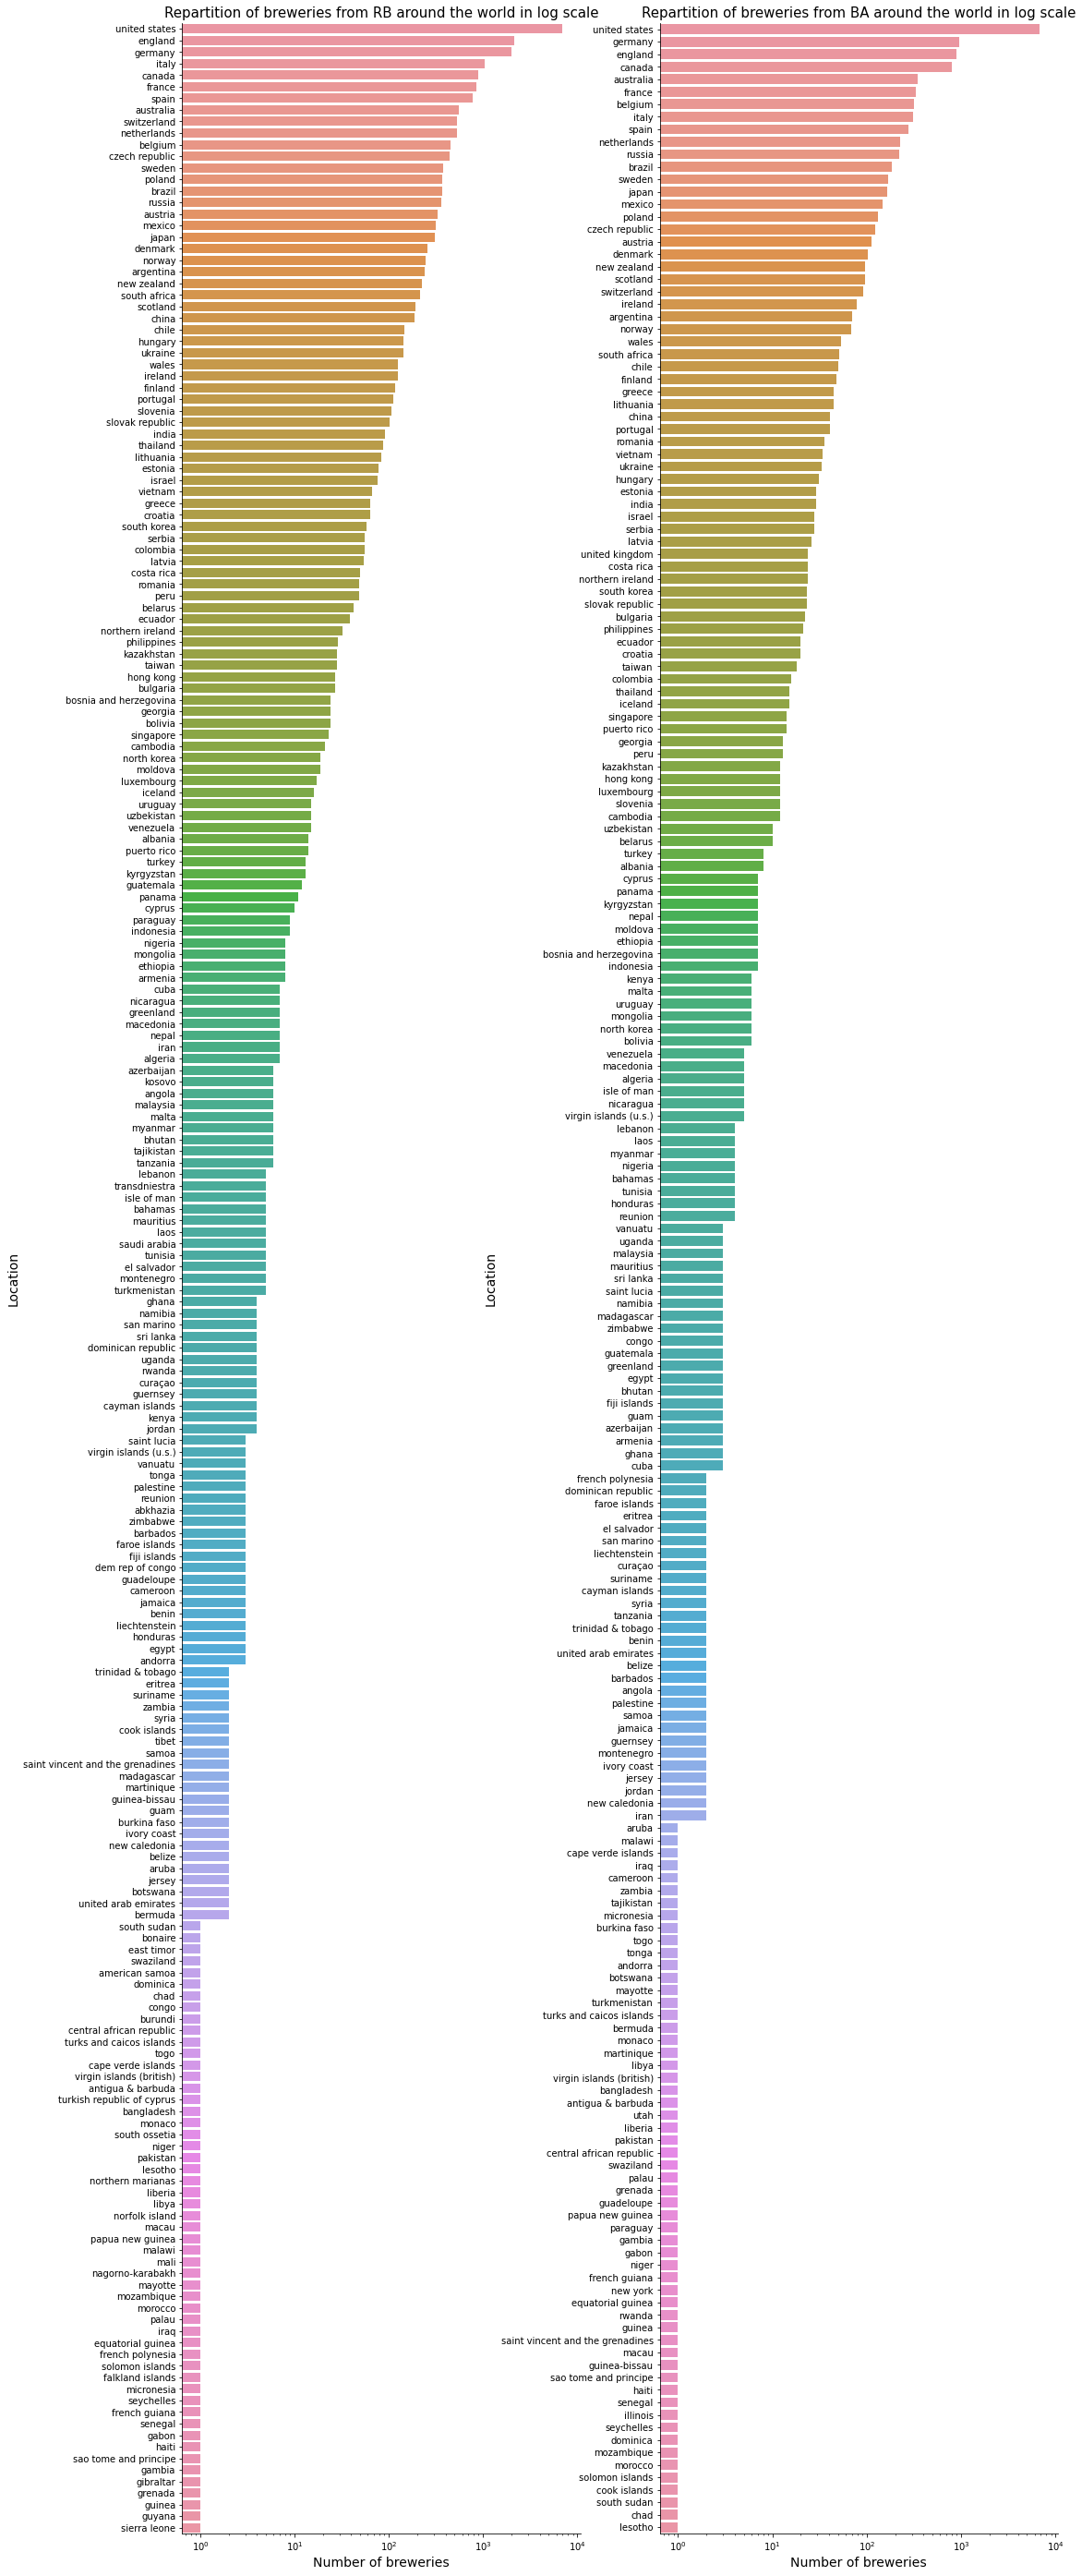

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(17, 50))

new_BA_breweries = BA_breweries.groupby('location').agg('count').sort_values(by=['id'], ascending=False)
new_RB_breweries = RB_breweries.groupby('location').agg('count').sort_values(by=['id'], ascending=False)

sns.barplot(data=new_RB_breweries, x=new_RB_breweries.id, y=new_RB_breweries.index, ax=ax[0])
ax[0].set_title("Repartition of breweries from RB around the world in log scale", fontsize = 15)
ax[0].set_xlabel("Number of breweries", fontsize = 14)
ax[0].set_ylabel("Location", fontsize = 14)
ax[0].set_xscale('log')
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

sns.barplot(data=new_BA_breweries, x=new_BA_breweries.id, y=new_BA_breweries.index, ax=ax[1])
ax[1].set_title("Repartition of breweries from BA around the world in log scale", fontsize = 15)
ax[1].set_xlabel("Number of breweries", fontsize = 14)
ax[1].set_ylabel("Location", fontsize = 14)
ax[1].set_xscale('log')
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

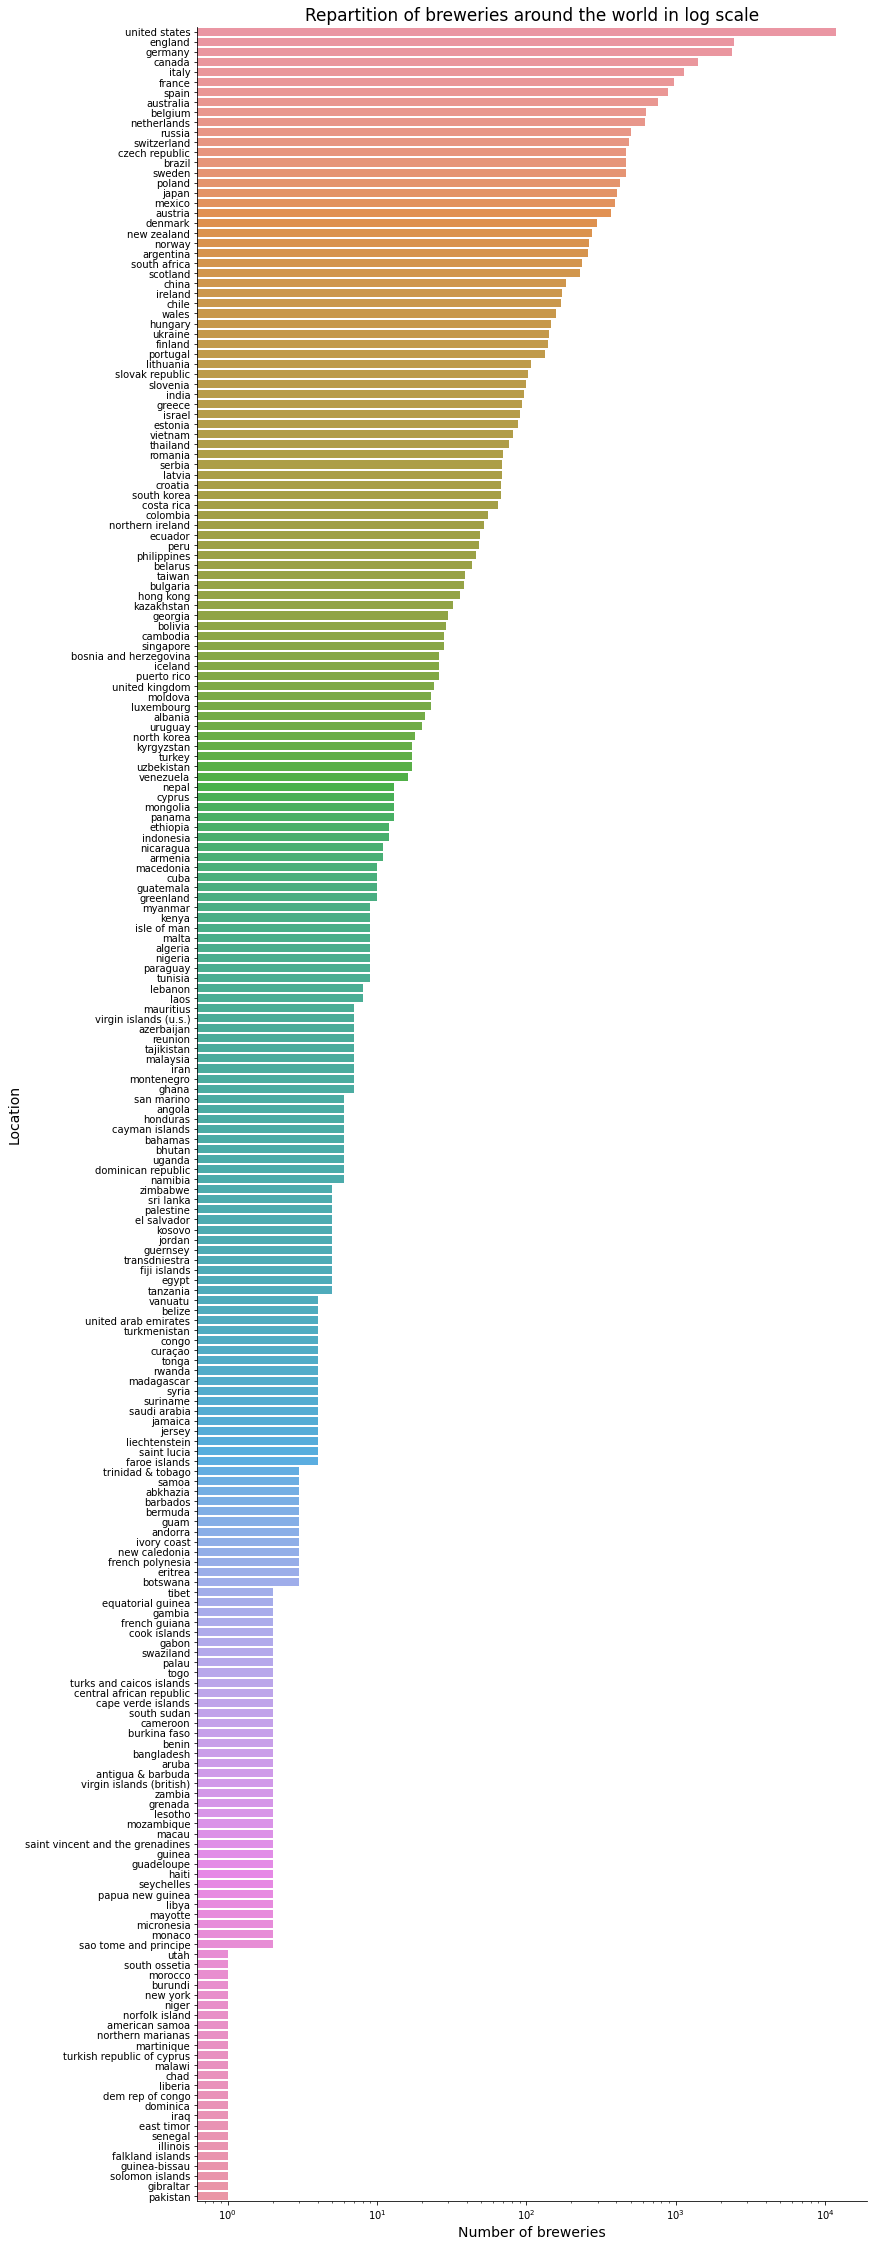

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(12,40))

new_breweries = breweries.groupby('location').agg('count').sort_values(by=['id'], ascending=False)

sns.barplot(data=new_breweries, x=new_breweries.id, y=new_breweries.index)
ax.set_title("Repartition of breweries around the world in log scale", fontsize = 17)
ax.set_xlabel("Number of breweries", fontsize = 14)
ax.set_ylabel("Location", fontsize = 14)
ax.set_xscale('log')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

- The log space version allows us to see the repartion of breweries in the other countries. In fact, real-world data is often skewed. For heavily skewed distributions, it’s better to define the bins in log space. 
- As we can see here, the most of our breweries are frome the United States with almost 7000 breweries. It could be interesting to see the repartition in the United State by states. In this way, it would be possible to match a person from America with a beer thanks to his state.
- We don't have enough data for countries like Pakistant or Estonia. Those countries will be named breweries_few and will be removed from the dataframe breweries_big because it is not representative of the country.

In [24]:
# Brings together countries without enough breweries
tresh_nbr_breweries = 50

locations = []
for location in list(breweries.location.unique()):
    if len(breweries.loc[breweries.location == location]) < tresh_nbr_breweries:
        locations.append(location)

breweries_few = pd.DataFrame(columns = ['id', 'location', 'name', 'nbr_beers', 'state'])
breweries_big = breweries.copy()

for location in locations:
    breweries_few = pd.concat([breweries_few, breweries.loc[breweries.location == location]])
    breweries_big = breweries_big.drop(breweries_big[breweries_big.location == location].index)

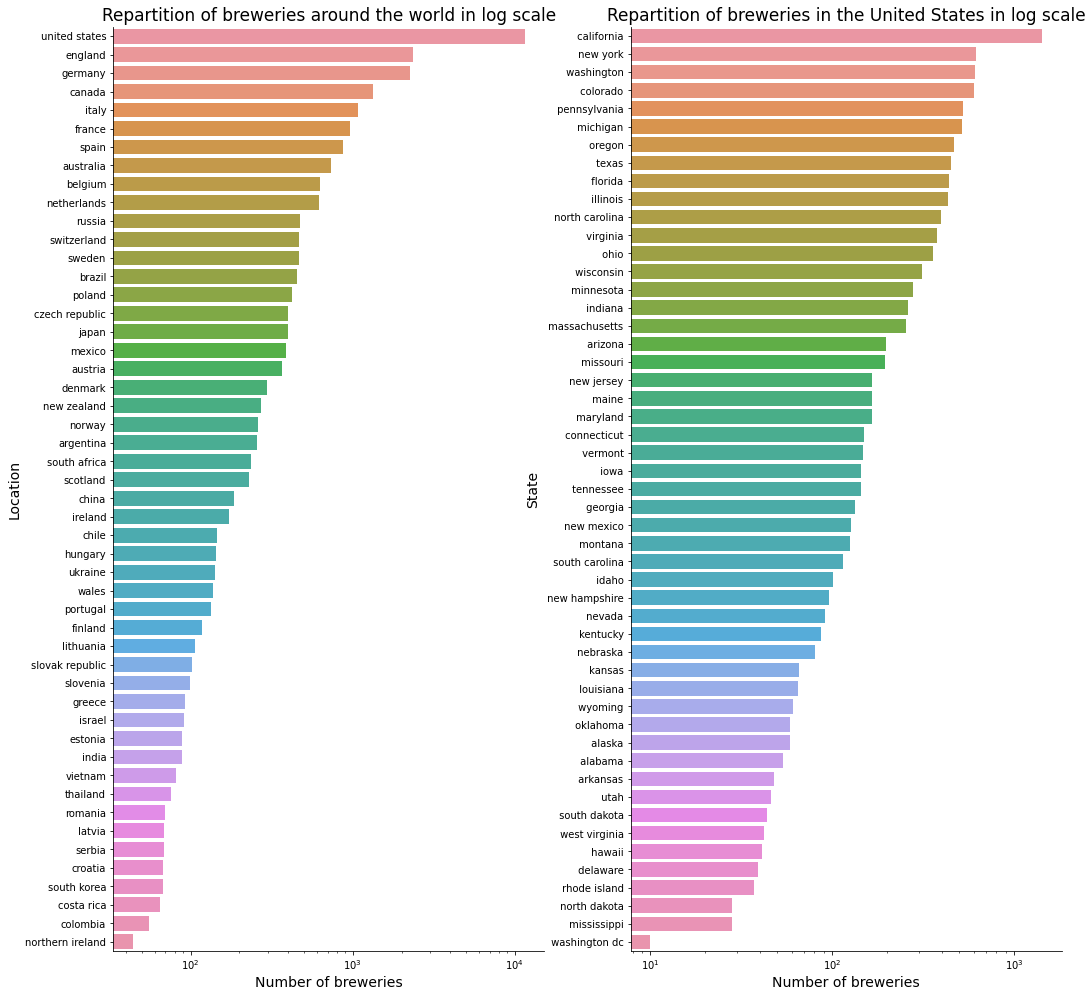

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(17, 17))

new_breweries_big = breweries_big.groupby('location').agg('count').sort_values(by=['id'], ascending=False)
breweries_US = breweries_big[breweries_big['location'] == 'united states']
breweries_US = breweries_US.drop(breweries_US[breweries_US.state == ' united states'].index)
new_breweries_US = breweries_US.groupby('state').agg('count').sort_values(by=['id'], ascending=False)

sns.barplot(data=new_breweries_big, x=new_breweries_big.id, y=new_breweries_big.index, ax=ax[0])
ax[0].set_title("Repartition of breweries around the world in log scale", fontsize = 17)
ax[0].set_xlabel("Number of breweries", fontsize = 14)
ax[0].set_ylabel("Location", fontsize = 14)
ax[0].set_xscale('log')
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

sns.barplot(data=new_breweries_US, x=new_breweries_US.id, y=new_breweries_US.index, ax=ax[1])
ax[1].set_title("Repartition of breweries in the United States in log scale", fontsize = 17)
ax[1].set_xlabel("Number of breweries", fontsize = 14)
ax[1].set_ylabel("State", fontsize = 14)
ax[1].set_xscale('log')
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

Finally, we had to remove some countries due to too little data. In addition, in order to match a beer with a person, the origin of a personn will be used but for the case of the United State, it could be interesting to be more precise and to use his state.

#### Interactive plots

## How users are distributed across the world? 

Now that we have a general vision of breweries distribution arounf the world, we can compare it to the users distribution. This will be intersting in the following to see if users prefer a beer from it's own country. We will only visualize 'active' people, that is to say whose number of reviews and grades is greater than a certain threshold.

#### The dataset of users:

In [26]:
BA_users = pd.read_csv(BA_users_file)
BA_users = regularize_locations(BA_users)
print(f'Number of users = {len(BA_users)}')
BA_users.head(10)

Number of users = 153704


,nbr_ratings,nbr_reviews,user_id,user_name,joined,location,state
0,7820,465,nmann08.184925,nmann08,1.199704e+09,united states,washington
1,2521,2504,stjamesgate.163714,StJamesGate,1.191838e+09,united states,new york
2,1797,1143,mdagnew.19527,mdagnew,1.116410e+09,northern ireland,NaN
3,31,31,helloloser12345.10867,helloloser12345,1.101380e+09,northern ireland,NaN
4,604,604,cypressbob.3708,cypressbob,1.069326e+09,northern ireland,NaN
5,2326,0,hellpop65.48993,Hellpop65,1.131966e+09,united states,kansas
6,3098,0,latarnik.52897,Latarnik,1.133521e+09,united states,new jersey
7,1866,23,rochefortchris.697017,RochefortChris,1.349172e+09,united states,north carolina
8,1131,188,okcnittany.144868,OKCNittany,1.182766e+09,united states,oklahoma
9,9987,16,jaydoc.265507,jaydoc,1.226488e+09,united states,kansas


In [27]:
RB_users = pd.read_csv(RB_users_file)
RB_users = regularize_locations(RB_users)
print(f'Number of users = {len(RB_users)}')
RB_users.head(10)

Number of users = 70174


,nbr_ratings,user_id,user_name,joined,location,state
0,1890,175852,Manslow,1.337508e+09,poland,NaN
1,89,442761,MAGICuenca91,1.484046e+09,spain,NaN
2,169,288889,Sibarh,1.384600e+09,poland,NaN
3,3371,250510,fombe89,1.363950e+09,spain,NaN
4,13043,122778,kevnic2008,1.296644e+09,germany,NaN
5,21024,227834,Beerhunter111,1.352718e+09,germany,NaN
6,8781,83106,Erzengel,1.224324e+09,germany,NaN
7,4051,37316,Lowenbrau,1.147860e+09,spain,NaN
8,435,75452,seynie,1.211278e+09,belgium,NaN
9,5795,17111,Cletus,1.100257e+09,united states,connecticut


In [28]:
# join the two dataframe
users = pd.concat([BA_users, RB_users])
users = users.drop_duplicates(subset=['user_id'], keep='first')

In [29]:
print(f'Number of users = {len(users)}')
print(f'Number of different contries from breweries = {len(list(users.location.unique()))}')

Number of users = 223824
Number of different contries from breweries = 202


#### Repartition of 'active' people

In [30]:
# threshold
tresh_nbr_reviews = 100
tresh_nbr_ratings = 0

In [31]:
active_users = users[(users['nbr_reviews'] > tresh_nbr_reviews) & (users['nbr_ratings'] > tresh_nbr_ratings)]

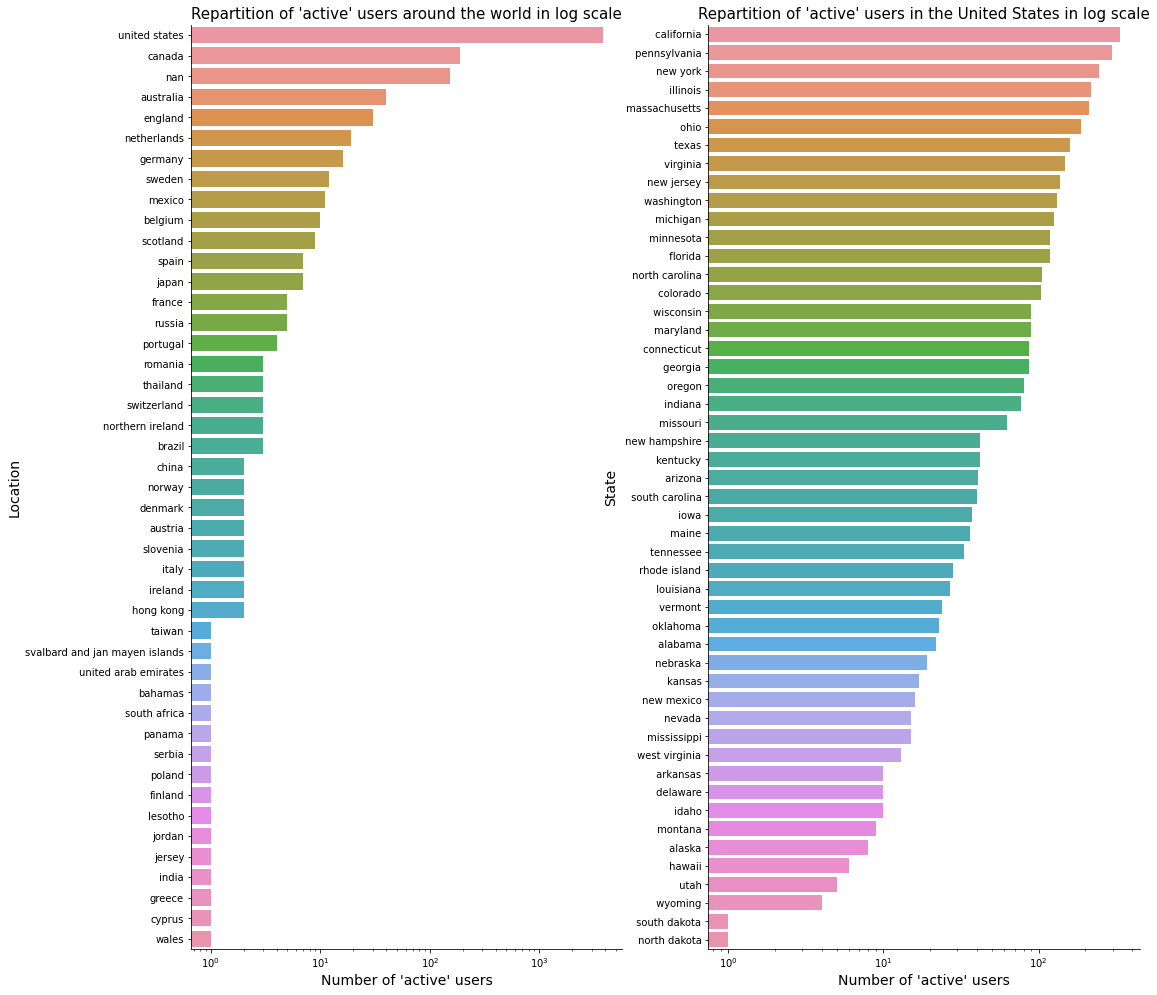

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(17, 17))

new_active_users = active_users.groupby('location').agg('count').sort_values(by=['user_id'], ascending=False)
users_US = active_users[active_users['location'] == 'united states']
new_users_US = users_US.groupby('state').agg('count').sort_values(by=['user_id'], ascending=False)

sns.barplot(data=new_active_users, x=new_active_users.user_id, y=new_active_users.index, ax=ax[0])
ax[0].set_title("Repartition of 'active' users around the world in log scale", fontsize = 15)
ax[0].set_xlabel("Number of 'active' users", fontsize = 14)
ax[0].set_ylabel("Location", fontsize = 14)
ax[0].set_xscale('log')
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

sns.barplot(data=new_users_US, x=new_users_US.user_id, y=new_users_US.index, ax=ax[1])
ax[1].set_title("Repartition of 'active' users in the United States in log scale", fontsize = 15)
ax[1].set_xlabel("Number of 'active' users", fontsize = 14)
ax[1].set_ylabel("State", fontsize = 14)
ax[1].set_xscale('log')
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

Here the majority of active users are frome the United States, Canada and Australia but we can also see that an important part of users didn't precise their nationality. So, we can't use datas from those users to match a person with a beer.

In [33]:
breweries_loc_US = pd.DataFrame(columns = ['id', 'location', 'name', 'nbr_beers', 'state'])

users_US = active_users[active_users['location'] == 'united states']
new_users_US = users_US.groupby('state').agg('count').sort_values(by=['user_id'], ascending=False)

for state in list(new_users_US.index):
    breweries_loc_US = pd.concat([breweries_loc_US, breweries.loc[breweries.state == state]])

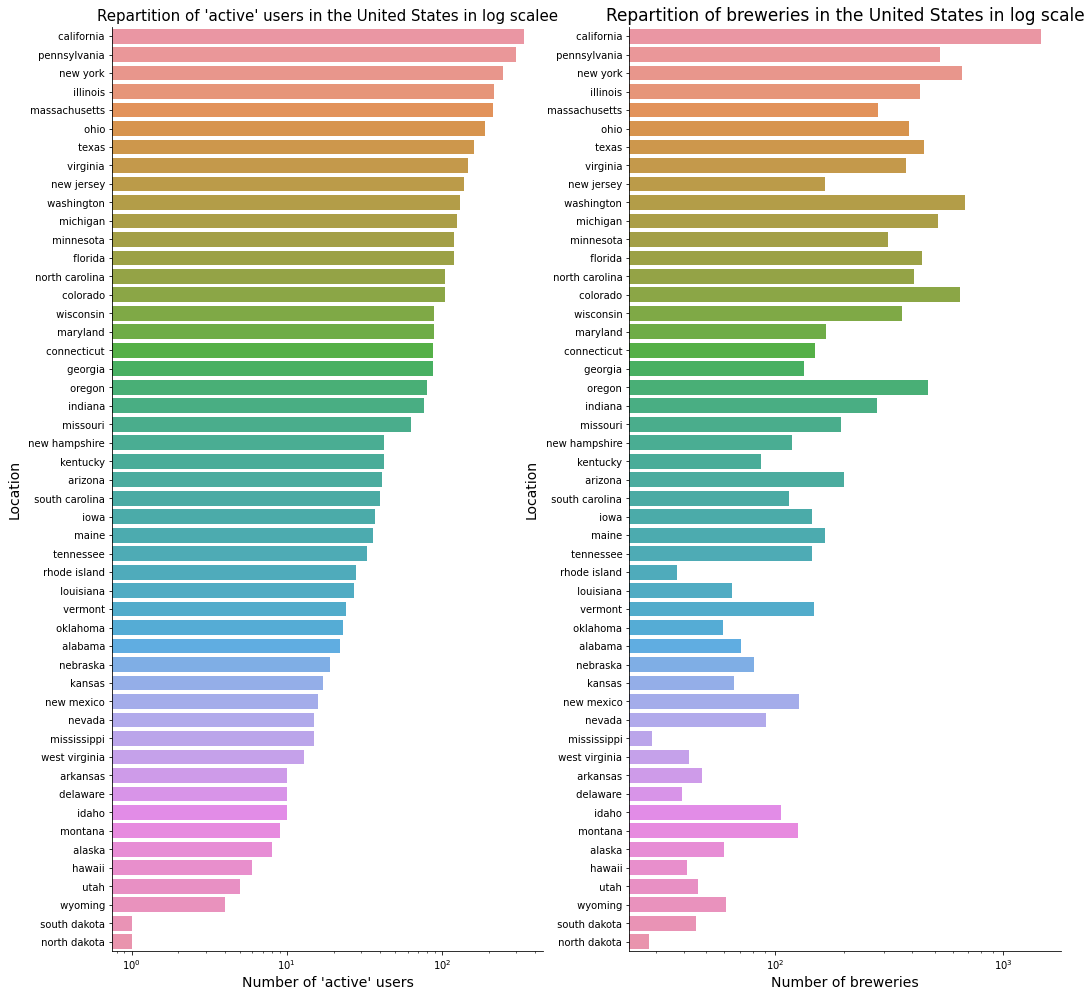

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(17, 17))

new_breweries_loc_US = breweries_loc_US.groupby('state').agg('count')
new_breweries_loc_US['user_id'] = new_users_US.user_id
new_breweries_loc_US = new_breweries_loc_US.sort_values(by=['user_id'], ascending=False)

sns.barplot(data=new_users_US, x=new_users_US.user_id, y=new_users_US.index, ax=ax[0])
ax[0].set_title("Repartition of 'active' users in the United States in log scalee", fontsize = 15)
ax[0].set_xlabel("Number of 'active' users", fontsize = 14)
ax[0].set_ylabel("Location", fontsize = 14)
ax[0].set_xscale('log')
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

sns.barplot(data=new_breweries_loc_US, x=new_breweries_loc_US.id, y=new_breweries_loc_US.index, ax=ax[1])
ax[1].set_title("Repartition of breweries in the United States in log scale", fontsize = 17)
ax[1].set_xlabel("Number of breweries", fontsize = 14)
ax[1].set_ylabel("Location", fontsize = 14)
ax[1].set_xscale('log')
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

In [35]:
active_users = active_users.drop(active_users[active_users.location == 'nan'].index, inplace=False)
breweries_loc = pd.DataFrame(columns = ['id', 'location', 'name', 'nbr_beers', 'state'])

new_active_users = active_users.groupby('location').agg('count').sort_values(by=['user_id'], ascending=False)

for loc in list(new_active_users.index):
    breweries_loc = pd.concat([breweries_loc, breweries.loc[breweries.location == loc]])

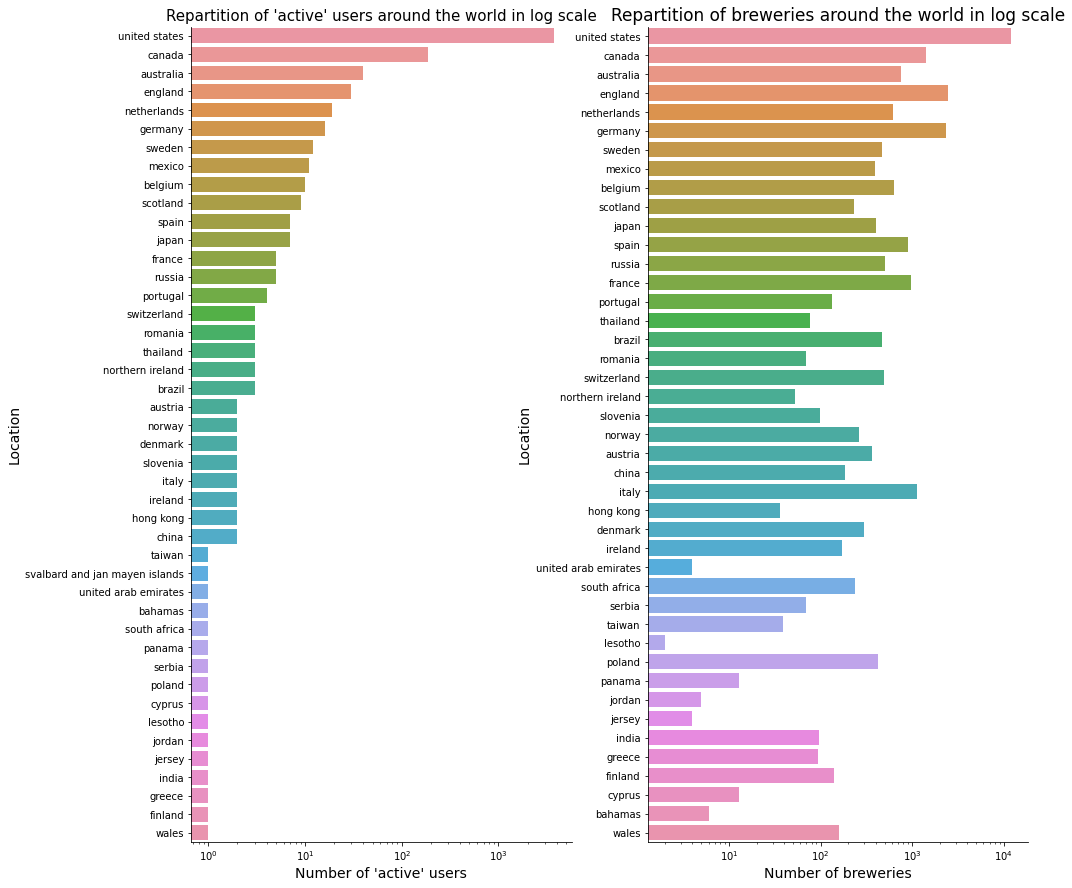

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(15, 15))

new_breweries_loc = breweries_loc.groupby('location').agg('count')
new_breweries_loc['user_id'] = new_active_users.user_id
new_breweries_loc = new_breweries_loc.sort_values(by=['user_id'], ascending=False)

sns.barplot(data=new_active_users, x=new_active_users.user_id, y=new_active_users.index, ax=ax[0])
ax[0].set_title("Repartition of 'active' users around the world in log scale", fontsize = 15)
ax[0].set_xlabel("Number of 'active' users", fontsize = 14)
ax[0].set_ylabel("Location", fontsize = 14)
ax[0].set_xscale('log')
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

sns.barplot(data=new_breweries_loc, x=new_breweries_loc.id, y=new_breweries_loc.index, ax=ax[1])
ax[1].set_title("Repartition of breweries around the world in log scale", fontsize = 17)
ax[1].set_xlabel("Number of breweries", fontsize = 14)
ax[1].set_ylabel("Location", fontsize = 14)
ax[1].set_xscale('log')
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

It is easy to see here that in our dataset the United States proposes the most beers and has also the most active people. Then it follows with Canada, England and Australia. We can see that the more beer a country offers, the more active a country is for the first bars. However after Taiwan we can observe that the people are not active when his country proposes more breweries. This can be explained by the fact that we don't have enough datas for those countries and by population size. In fact the population in the United States and Canada is much more bigger than in European countries.

Another factor may be that the country certainly offers a lot of brewery but little choice in the brewery.

#### Repartition of beers

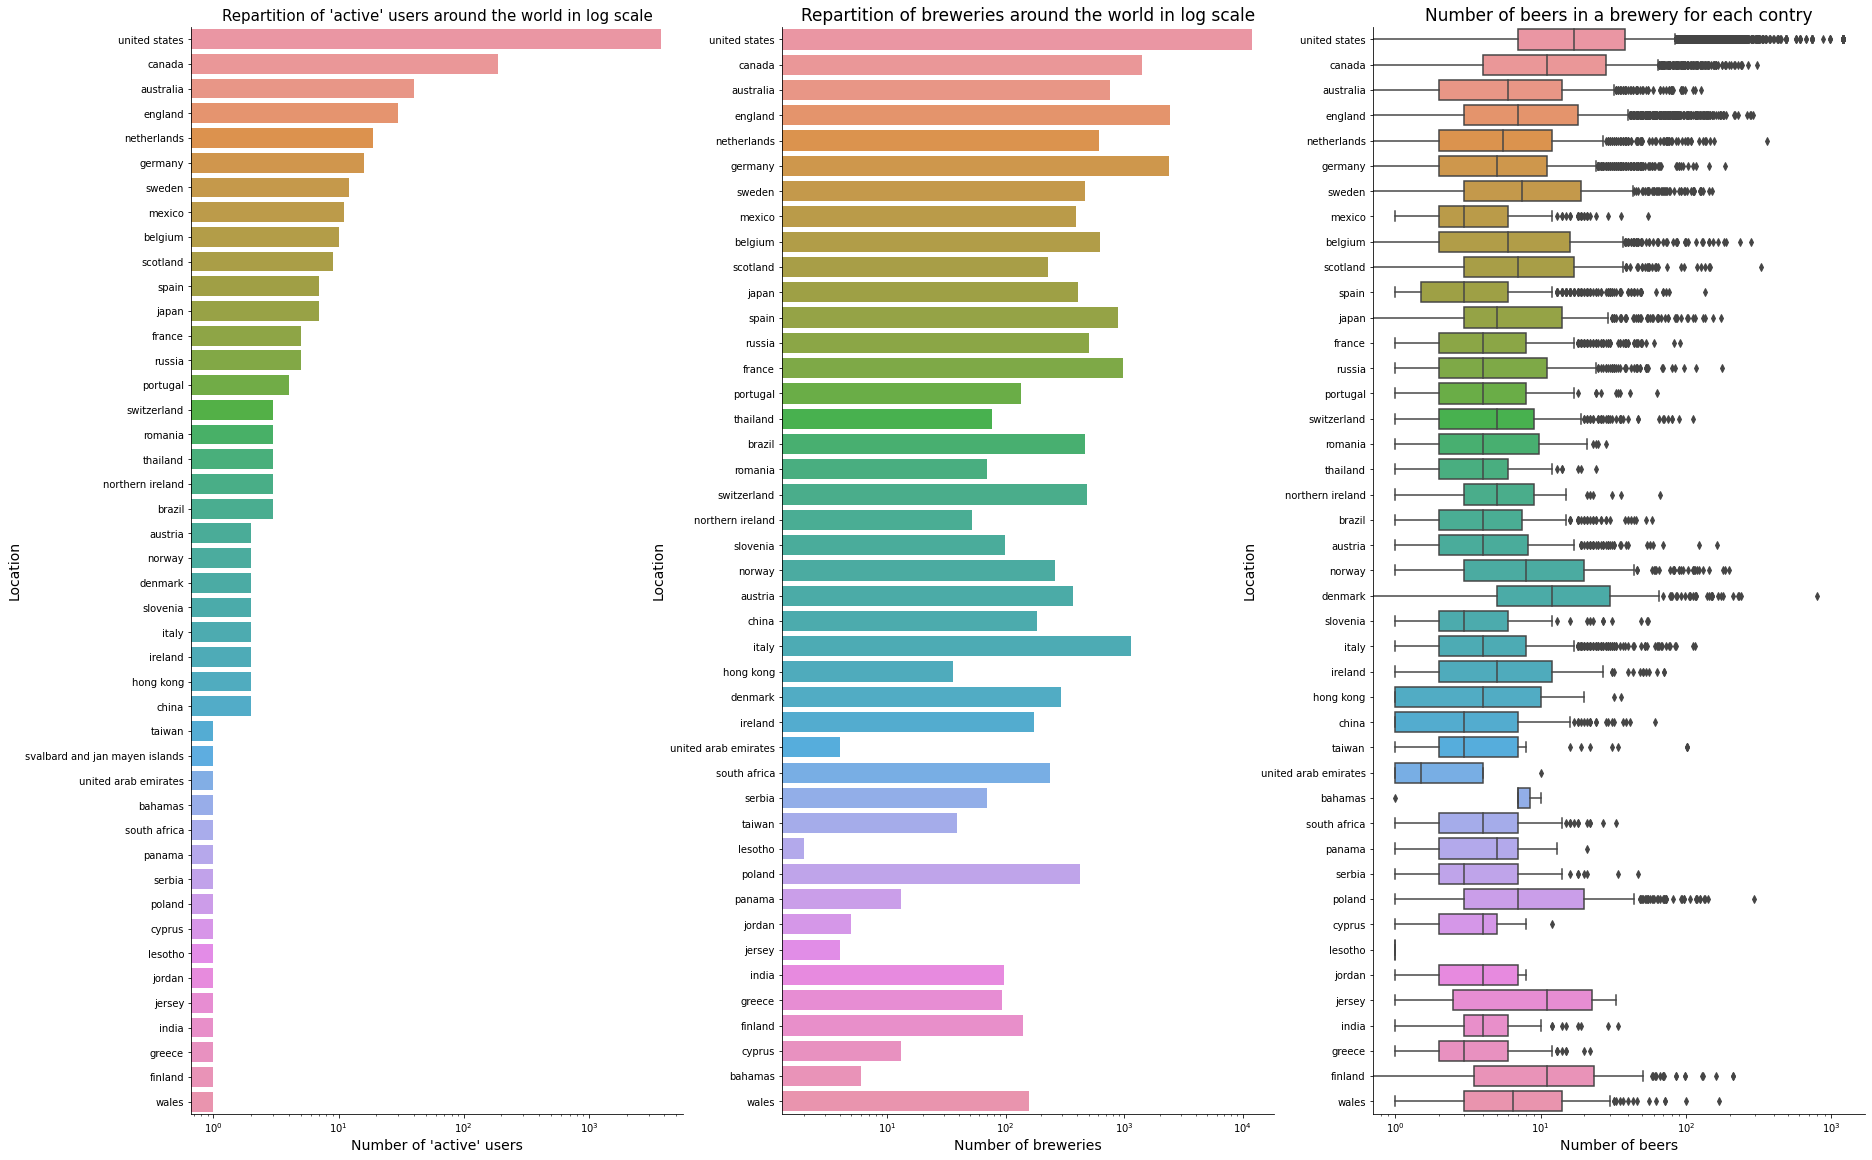

In [37]:
fig, ax = plt.subplots(1, 3, figsize=(30, 20))

new_breweries_loc = breweries_loc.groupby('location').agg('count')
new_breweries_loc['user_id'] = new_active_users.user_id
new_breweries_loc = new_breweries_loc.sort_values(by=['user_id'], ascending=False)

sns.barplot(data=new_active_users, x=new_active_users.user_id, y=new_active_users.index, ax=ax[0])
ax[0].set_title("Repartition of 'active' users around the world in log scale", fontsize = 15)
ax[0].set_xlabel("Number of 'active' users", fontsize = 14)
ax[0].set_ylabel("Location", fontsize = 14)
ax[0].set_xscale('log')
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

sns.barplot(data=new_breweries_loc, x=new_breweries_loc.id, y=new_breweries_loc.index, ax=ax[1])
ax[1].set_title("Repartition of breweries around the world in log scale", fontsize = 17)
ax[1].set_xlabel("Number of breweries", fontsize = 14)
ax[1].set_ylabel("Location", fontsize = 14)
ax[1].set_xscale('log')
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

sns.boxplot(x="nbr_beers", y="location", data=breweries_loc, ax=ax[2])
ax[2].set_title("Number of beers in a brewery for each contry", fontsize = 17)
ax[2].set_xlabel("Number of beers", fontsize = 14)
ax[2].set_ylabel("Location", fontsize = 14)
ax[2].set_xscale('log')
ax[2].spines['right'].set_visible(False)
ax[2].spines['top'].set_visible(False)

We can observe that the number of beers offers in a brewery seems to be approximatly the same in every country. However, in addition to be the countries which have the more breweries, the United States and Canada are countries with the most choice of beers in a brewery.

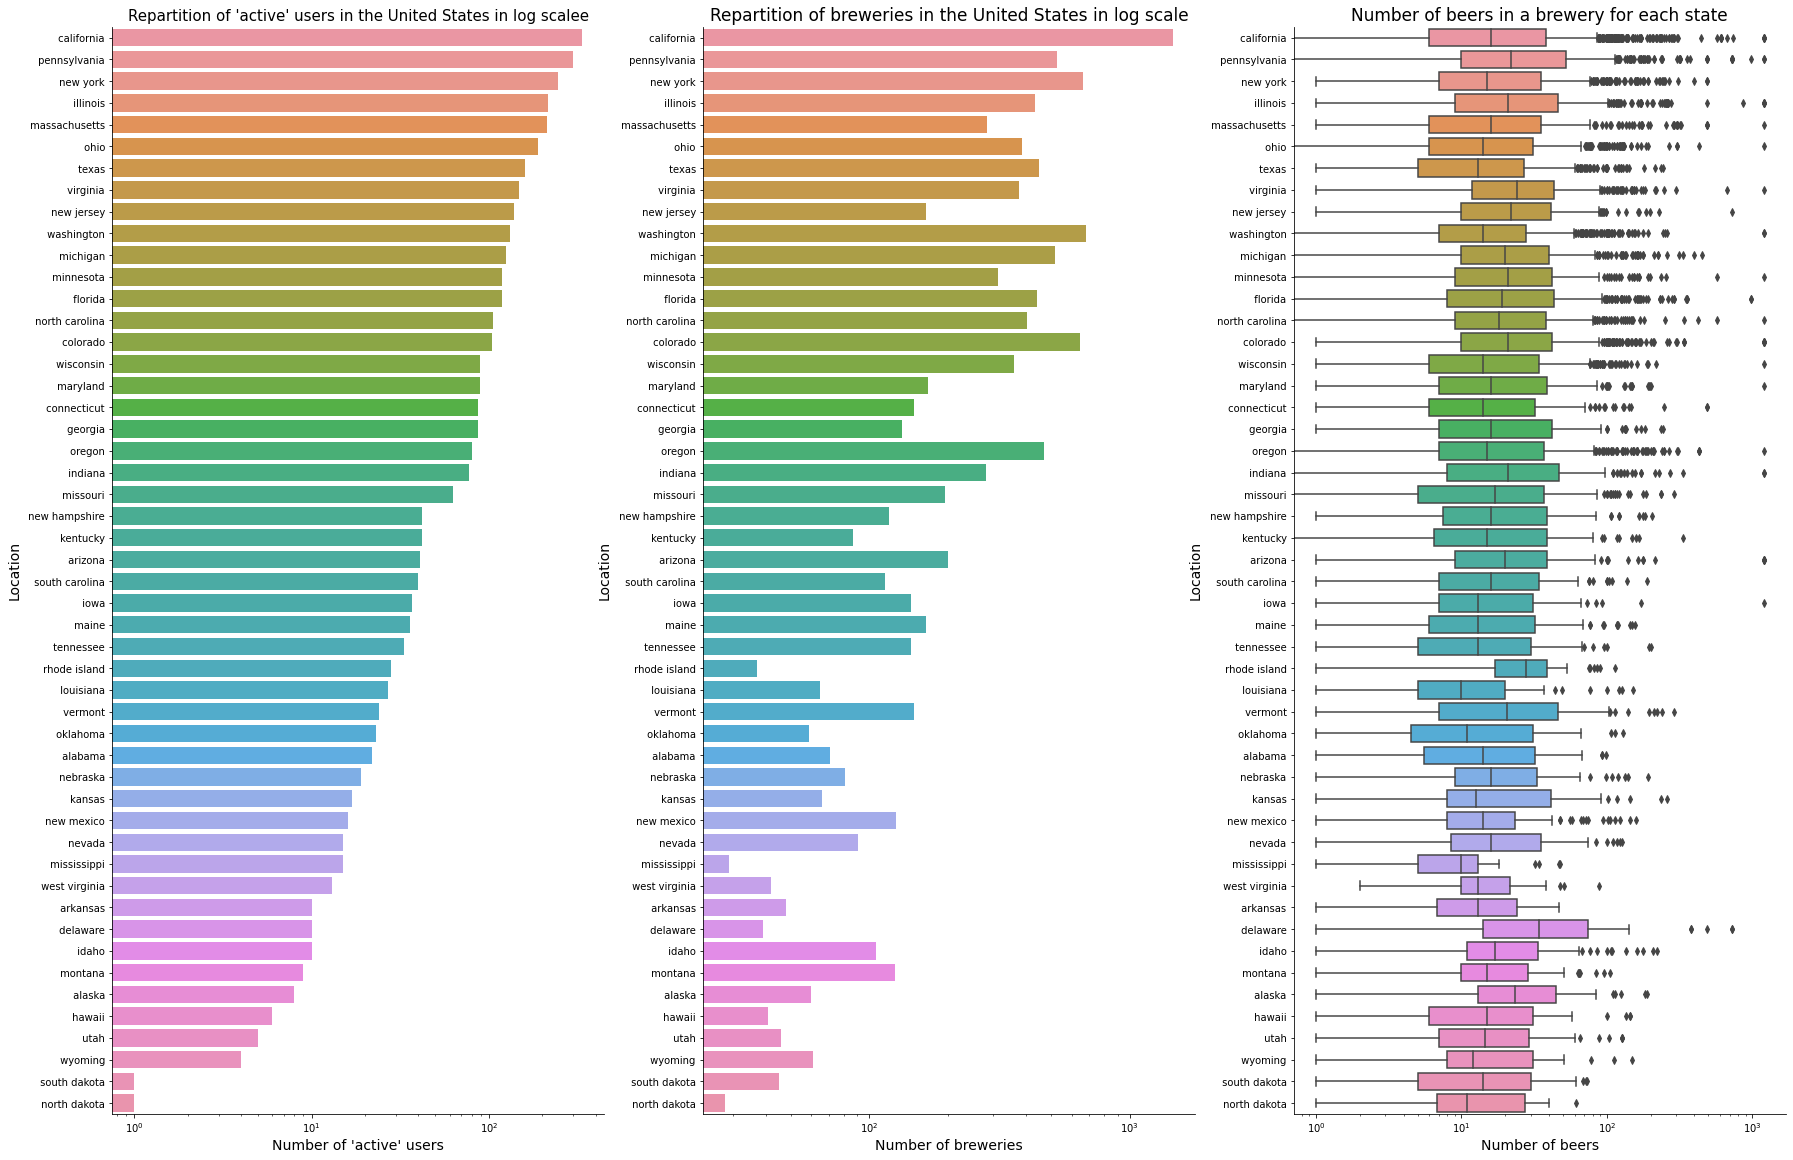

In [38]:
fig, ax = plt.subplots(1, 3, figsize=(30, 20))

new_breweries_loc_US = breweries_loc_US.groupby('state').agg('count')
new_breweries_loc_US['user_id'] = new_users_US.user_id
new_breweries_loc_US = new_breweries_loc_US.sort_values(by=['user_id'], ascending=False)

sns.barplot(data=new_users_US, x=new_users_US.user_id, y=new_users_US.index, ax=ax[0])
ax[0].set_title("Repartition of 'active' users in the United States in log scalee", fontsize = 15)
ax[0].set_xlabel("Number of 'active' users", fontsize = 14)
ax[0].set_ylabel("Location", fontsize = 14)
ax[0].set_xscale('log')
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

sns.barplot(data=new_breweries_loc_US, x=new_breweries_loc_US.id, y=new_breweries_loc_US.index, ax=ax[1])
ax[1].set_title("Repartition of breweries in the United States in log scale", fontsize = 17)
ax[1].set_xlabel("Number of breweries", fontsize = 14)
ax[1].set_ylabel("Location", fontsize = 14)
ax[1].set_xscale('log')
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

sns.boxplot(x="nbr_beers", y="state", data=breweries_loc_US, ax=ax[2])
ax[2].set_title("Number of beers in a brewery for each state", fontsize = 17)
ax[2].set_xlabel("Number of beers", fontsize = 14)
ax[2].set_ylabel("Location", fontsize = 14)
ax[2].set_xscale('log')
ax[2].spines['right'].set_visible(False)
ax[2].spines['top'].set_visible(False)

< comments >

#### Conclusion

Finally, the logic would be that the more a country offers breweries, the more the people in the country will be 'active' but this is not always the case. This may be due to our data sources, as we do not have enough information on certain countries. Or by the choice of beers in each brewery. In fact, maybe a country offers many breweries but not lot of beers. This means that people in this country don't drink many beers and so, are not as 'active' as expected.

To continue, another idea will be talked in the next part. In fact, this idea would be that a person would be subject to biases. Indeed, a person will more easily appreciate the beers of his region or the beers offered in his region in addition to be more active. In fact, we already saw that the number of breweries and beers in a contry is kind of corrolated to the activity of users. However, in the following, we have to keep in mind that most of our datas are from the United States

# 2. Analysis of user preferences

## Relationship between user's country and beer origin

Let's have a look at possible indicators that may suggest correlations between the users country and the beers they review and prefer. 

#### In the following we will use the same datasets and function to read them as the section before

#### The dataset of reviews:

In [39]:
BA_reviews = read_sample_reviews_file(BA_sample_file)
print(f'number of reviews = {len(BA_reviews)}')
BA_reviews.head(1)

number of reviews = 111111


,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review
0,Régab,142544,Societe des Brasseries du Gabon (SOBRAGA),37262,Euro Pale Lager,4.5,2015-08-20 12:00:00,nmann08,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88,"From a bottle, pours a piss yellow color with...",True


In [40]:
RB_reviews = read_sample_reviews_file(RB_sample_file)
print(f'number of reviews = {len(RB_reviews)}')
RB_reviews.head(1)

number of reviews = 58


,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review
0,33 Export (Gabon),410549,Sobraga,3198,Pale Lager,5.0,2016-04-26 12:00:00,Manslow,175852,2.0,4.0,2.0,4.0,8.0,2.0,"Puszka 0,33l dzięki Christoph . Kolor jasnozł...",True


In [41]:
# join the two dataframe
reviews = pd.concat([BA_reviews, RB_reviews])
reviews = reviews.drop_duplicates(subset=['beer_id', 'user_id'], keep='first')
print(f'number of reviews = {len(reviews)}')
reviews.head(1)

number of reviews = 111169


,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review
0,Régab,142544,Societe des Brasseries du Gabon (SOBRAGA),37262,Euro Pale Lager,4.5,2015-08-20 12:00:00,nmann08,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88,"From a bottle, pours a piss yellow color with...",True


#### The dataset of users:

In [42]:
# remove users which location is not specified
users = users.drop(users[users.location == 'nan'].index, inplace=False)
print(f'Number of users = {len(users)}')
users.head(1)

Number of users = 148989


,nbr_ratings,nbr_reviews,user_id,user_name,joined,location,state
0,7820,465.0,nmann08.184925,nmann08,1.199704e+09,united states,washington


In [43]:
users_country_list = list(users.location.unique())
print(f'Number of different contries form users = {len(users_country_list)}')

Number of different contries form users = 190


Storing the users' origin in a dictionary

In [44]:
users_contry_dict = dict(zip(users.user_id, users.location))

#### The dataset of breweries:

In [45]:
# remove breweries which location is not specified
breweries = breweries.drop(breweries[breweries.location == 'nan'].index, inplace=False)
print(f'Number of breweries = {len(breweries)}')
breweries.head(1)

Number of breweries = 32587


,id,location,name,nbr_beers,state
0,39912,kyrgyzstan,Abdysh-Ata (Абдыш Ата),5,NaN


In [46]:
print(f'Number of different contries from breweries = {len(list(breweries.location.unique()))}')

Number of different contries from breweries = 216


Storing the breweries' origin in a dictionary

In [47]:
breweries_contry_dict = dict(zip(breweries.id, breweries.location))

#### Combining reviews, users and breweries:

For each review, we will check if the origin of the user (reviewer) is the same as the brewery (whose beer is being reviewed), marking it with a `1` if the contries match and `0` otherwise.

Merging users and breweries origin (filtering out cases where location in unknown):

In [48]:
def get_country(id, correspondance_dict):
    if id in correspondance_dict:
        return correspondance_dict[id]
    else:
        return np.nan

In [49]:
reviews.head(1)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review
0,Régab,142544,Societe des Brasseries du Gabon (SOBRAGA),37262,Euro Pale Lager,4.5,2015-08-20 12:00:00,nmann08,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88,"From a bottle, pours a piss yellow color with...",True


In [50]:
reviews['user_country'] = reviews['user_id'].apply(
    lambda x: get_country(id=x, correspondance_dict=users_contry_dict)
)
reviews['brewery_country'] = reviews['brewery_id'].apply(
    lambda x: get_country(id=x, correspondance_dict=breweries_contry_dict)
)
reviews = reviews.dropna()

Creating a column to store if country is the same:

In [51]:
def is_contry_the_same(contry1, country2):
    if contry1==country2: 
        return 1
    else:
        return 0

In [52]:
reviews['is_same_country'] = reviews.apply(lambda row: is_contry_the_same(row.user_country, row.brewery_country), axis=1)

To check if the difference in origin between the user and beer is statistically significant across reviews, we will compute the 95% confidence intervals (using `scipy.stats`) of the generated column `is_same_country`:

In [53]:
def get_confidence_interval(data, title=None):
    interval = st.t.interval(alpha=0.95,
                df=len(data)-1,
                loc=np.mean(data), 
                scale=st.sem(data))
    print('--------------------------')
    if title:
        print(title)
    print()
    print(f'''Average = {np.mean(data)}
Confidence interval = {interval}''')
    print('--------------------------')
    return interval

In [54]:
interval = get_confidence_interval(list(reviews.is_same_country), "Comparison between user and beer origin from all reviews:")

--------------------------
Comparison between user and beer origin from all reviews:

Average = 0.08035288507391512
Confidence interval = (0.07815404392920189, 0.08255172621862836)
--------------------------


This result indicates that, in general, for all reviews, the country of the user (reviewer) tend to not be the same as the beer being reviewed. In fact, this would be expected, as the probability of any given country being one's (unique) contry of origin is very low, given that there are many more countries which are not this person's country.

What we want to investigate further here is the user's *preference* as a function of contry, which can be hidden inside the gross number of reviews. 

#### Metrics to capture user's preference

Some initial ideas to capture the users preferences are related to analyzing what are the styles and contries of origin of each person's most frequent reviews, as well as the individual's best rated reviews. 

This type of analysis can be done with the following function, which we intend to develop and build upon in the third phase of the project:

In [55]:
def get_user_preferences_df(reviews, number_of_reviews_threshold=10):
    grouped = reviews.groupby('user_id')
    data = []
    for user_id, group in grouped:
        if len(group) >= number_of_reviews_threshold:
            row_dict = {}
            row_dict['user_id'] = user_id
            row_dict['user_country'] = users_contry_dict[user_id]

            most_frequent_style = group['style'].value_counts().idxmax()
            row_dict['most_frequent_style'] = most_frequent_style

            most_frequent_country = group['brewery_country'].value_counts().idxmax()
            row_dict['most_frequent_country'] = most_frequent_country

            highest_rated_index = group['rating'].idxmax()
            highest_rated_beer = reviews.loc[highest_rated_index]
            row_dict['highest_rating'] = highest_rated_beer.rating
            row_dict['highest_rated_origin'] = highest_rated_beer.brewery_country

            row_dict['is_country_same_as_highest_rated'] = 1 if highest_rated_beer.brewery_country == users_contry_dict[user_id] else 0
            row_dict['is_country_same_as_most_frequent'] = 1 if most_frequent_country == users_contry_dict[user_id] else 0

            avg_rating_per_style = group.groupby(['style'])['rating'].mean().to_dict()
            row_dict['highest_rated_style'] = max(avg_rating_per_style, key=avg_rating_per_style.get)
            row_dict['lowest_rated_style'] = min(avg_rating_per_style, key=avg_rating_per_style.get)

            # row_dict['favorite_beers_avg_rating'] = group[group['style'] == most_frequent_style]['rating'].mean()
            # row_dict['other_beers_avg_rating'] = group[group['style'] != most_frequent_style]['rating'].mean()

            data.append(row_dict)
    return pd.DataFrame(data)

In order to have a solid grasp of each individuals preferences, we decided to consider individuals with at the number of least $n$ different ratings. (Although this can reduce the number of instances in  our analysis, it makes the estimation of the user's preferences more robust).

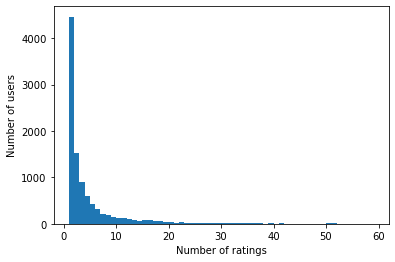

In [56]:
fig = plt.figure().set_size_inches(6,4)
number_of_reviews = reviews.value_counts('user_id').values
bins = np.arange(1, 60, 1)
plt.ylabel('Number of users')
plt.xlabel('Number of ratings')
plt.hist(number_of_reviews, bins=bins)
plt.show()

In [57]:
number_of_reviews

array([613, 562, 522, ...,   1,   1,   1], dtype=int64)

Here, we would like compare how the most reviewed country for each individual and the origin of her/his highest rated beer relates to its own country. For this reason, we compute the average values and confidence intervals for both the `is_country_same_as_highest_rated` and `is_country_same_as_most_frequent` fields generated below.

In [58]:
user_prefs_df = get_user_preferences_df(reviews)

In [59]:
interval = get_confidence_interval(list(user_prefs_df.is_country_same_as_most_frequent), "Comparison between user and beer origin for most frequent beer country:")

--------------------------
Comparison between user and beer origin for most frequent beer country:

Average = 0.04909365558912387
Confidence interval = (0.03744040130982164, 0.0607469098684261)
--------------------------


In [60]:
interval = get_confidence_interval(list(user_prefs_df.is_country_same_as_highest_rated), "Comparison between user and beer origin for highest rated review:")

--------------------------
Comparison between user and beer origin for highest rated review:

Average = 0.03700906344410876
Confidence interval = (0.02682711691285854, 0.04719100997535898)
--------------------------


As it can be observed in this preliminary analysis, the average value of the most frequent beer country is higher than the country of the highest reviews for each individual. This can point to a be subtle trend for the users reviewing on average more beers from their own country, but not necessarly having these beers as their favorite (they can be from a different country).

Improved versions of these type of analysis are planned to be made in the third part of the project, accounting for all ratings from both beer reviews websites. Among other things, further care will be taken to analysis cases where 
inherant imbalances in the dataset between beers and reviews may affect the final results and conclusions 

#### Illustrative analysis

Beyond computing metrics, we plan to make interactive visualizations of the prefered beers across styles and countries around the world, in a way that may support our insights from the data generated. Illustrative analysis relate the user's country of origin and beer style as follows:

In [61]:
def get_beer_style_matrix(df, category, n_most_frequent=20):
    new_df = df[['user_country', category]].copy()
    most_frequent_countries = list(new_df['user_country'].value_counts()[:n_most_frequent].keys())
    most_frequent_styles = list(new_df[category].value_counts()[:n_most_frequent].keys())

    new_df.user_country = new_df.user_country.astype("category")
    new_df.user_country = new_df.user_country.cat.set_categories(most_frequent_countries)
    new_df.sort_values(['user_country'])
    
    new_df[category] = new_df[category].astype("category")
    new_df[category] = new_df[category].cat.set_categories(most_frequent_styles)
    new_df.sort_values([category])

    new_df = new_df[new_df['user_country'].isin(most_frequent_countries)]
    new_df = new_df[new_df[category].isin(most_frequent_styles)]
    new_df['count'] = 1
    new_df = pd.pivot_table(new_df, values=['count'], index=['user_country'],
                        columns=[category], aggfunc=np.sum, fill_value=0)
    return new_df['count'], n_most_frequent

Text(0.5, 1.0, "Normalize beer preferences across countries:\nuser's country $\\times$ its most frequent style of beer\n(only shown for top 20 countries and styles)")

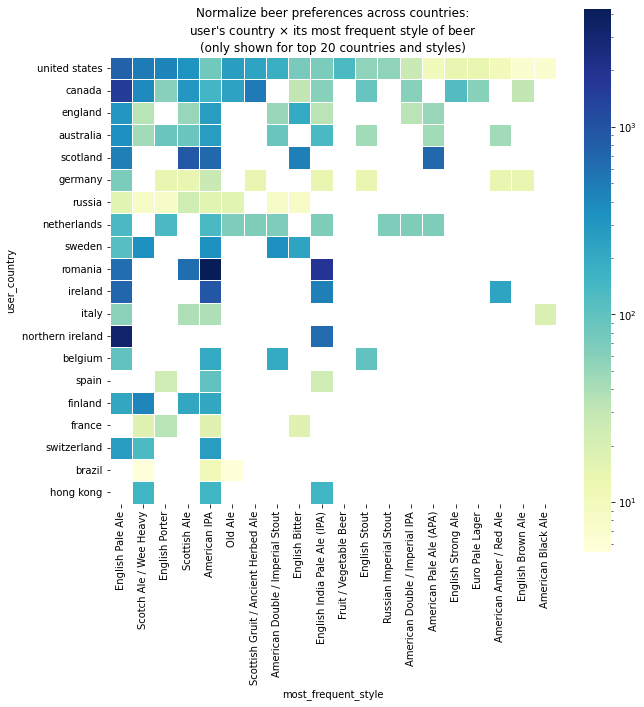

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

most_frequent_df, n_most_frequent = get_beer_style_matrix(
    df=user_prefs_df,
    category='most_frequent_style'
)
population=pd.DataFrame({'location':[location for location in most_frequent_df.index],
                  'population': [population_dict[location] for location in most_frequent_df.index]})
population['population'] = [pop/sum(list(population.population)) for pop in list(population.population)]
population = population.set_index('location')

new_most_frequent_df = most_frequent_df.head(0)
for index, row in most_frequent_df.iterrows():
    new_most_frequent_df = pd.concat([new_most_frequent_df, most_frequent_df.loc[most_frequent_df.index == index, :]/float(population.loc[population.index == index, 'population'])])

sns.heatmap(new_most_frequent_df, cmap="YlGnBu", linewidths=.6, square=True, norm=LogNorm())

plt.title(f'''Normalize beer preferences across countries:
user's country $\\times$ its most frequent style of beer
(only shown for top {n_most_frequent} countries and styles)''')

# 3. Analysis of beer attributes

The dataset from BeerAdvocate provide ratings for different beer caracteristics, let's have a look at them:

In [ ]:
reviews.head(1)

In [ ]:
beer_attributes = ['appearance', 'aroma', 'palate', 'taste']
for att in beer_attributes + ['overall', 'rating']:
    reviews[att] = reviews[att].astype(float)
reviews = reviews.dropna()
beer_attributes_df = reviews[beer_attributes]
beer_attributes_df.describe()

The average values over attributes seems pretty close, but is there any specific ones that have higher influences over the final rating?

One way to check this can be by paired t-testing:

In [ ]:
ratings_list = list(reviews.rating)
for att in beer_attributes:
    attribute_list = list(reviews[att])
    
    statistic, pvalue = st.ttest_rel(
        a=attribute_list,
        b=ratings_list
    )

    print(f'''
Attribute = {att}
t statistics = {statistic}
p-value = {pvalue}

-------------------------------------''')


For this general dataset, with a sample of the first 111111 reviews, there seems to be no particular correlation with the review of any beer attribute with the final rating.

What we are going to do here is test this hypothesis further by i) using the full data, ii) analysing individual styles of beer and iii) analysing if the average values given for each attribute changes over countries. 

# 4.  Recommender system
The fist step use a k-NN algorithm to select the top K users who share the same rating patterns. To performs a k-NN one must choose two important parameters : k and the similarity metric

1) Similarity metric between two user x and y : Pearson correlation

$$
{\displaystyle \operatorname {simil} (x,y)= d_{ecdn} = \sqrt{\displaystyle\sum_{i=1}^{n} (x_i-y_i)^2}}
$$

Where $I_{xy}$ is the set of item rated by both users, $r_{y,i}$ is the rating of user y for the item i and ${\bar {r_{x}}=\dfrac{1}{I_{x}}{\sum \limits _{i\in I_{x}}r_{x,i}}}$.

There is plenty of other different ways to calculate the similarity. It could be interesting to evulate how it impact the recommender system but it has been already discussed in previous papers. (https://arxiv.org/abs/1301.7363)

2) Choosing K

It's impossible to answer alredy give an answer, the k-NN algorithm has to be tested with different k to evualte what's which gives the lowest error using leave-one-out (LOO) cross-validation.

The second step is based on the next formula to predict the rate of the active user x for a beer i rated by all the user y in K:

$$r_{x,i}={\bar {r_{x}}}+k\sum \limits _{y\in K}\operatorname {simil} (x,y)(r_{y,i}-{\bar {r_{y}}})$$

It is now possible to recommend for the user x the beer with the highest precdicted rate.

There is two issues here : scalabilty and sparsity.



### Sparsity

The user-based recommender system is based on the fact that two different users rated the same beer. But there is certainly a lot users with little or no shared ratings. Let's try to evaluate it by showing the perrcentage beers with less than 5 ratings.


In [ ]:
(len(beers_ba[beers_ba.nbr_ratings<5])/len(beers_ba))*100

So there is 65.76% of beers with less than 5 reviews, which will of course impact the result of the recommender system. It will be bias and will have more probability to recommend the 34,24% beers becaus they have more reviews thus are more likely to be shared by two users.
### Sclalabity

There is no real way of dealing with that problem other than minimizing the recommender system algorithm. There is the possibility of trying diffrent method aplication for the recommender system but here we will stick with the user-based collaborative filtering method.
### KNN model
The features would be a set of all the ratings for each beers (taking only the beers rated by the active user). Having thus a dimension of n = #beers rated.

The outcome would be the users id.

So giving the set of rates made by the active user we would predict the top K nearest users and then predict the rate of the active user for all the beer already rated by the K users.